# Solar Cycle and Solar Flare Plots

In this notebook we look at the frequency of solar flares and the occurance with respect to the sunspot number. I'm only focusing on the past 3 solar cycles - i.e Solar Cycles 22, 23, 24 from 1986 - 2019. 


### Data used
* The sunspot number is recorded daily. The data used in this notebook is the monthly sunspot number csv file which can be downloaded here http://www.sidc.be/silso/datafiles (Source: WDC-SILSO, Royal Observatory of Belgium, Brussels).

* The GOES flare catalogue is accessed through the Heliophysics Event Knowledgebase (HEK) using the API provided by SunPy (see https://sunpy.org/ and also the nice example in the gallery [here](https://docs.sunpy.org/en/stable/generated/gallery/acquiring_data/querying_the_GOES_event_list.html#sphx-glr-generated-gallery-acquiring-data-querying-the-goes-event-list-py))



There are probably some nicer ways to do some of the things in this notebook, but it's just a test bed to play around with the data and make some plots you may need for a talk, some introductions to a thesis etc. 



In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter
from matplotlib import dates, colors
import seaborn as sns
from sunpy.net import hek
from sunpy.time import parse_time
import pandas as pd
import datetime
from scipy import fftpack

In [3]:
# plotting styles
sns.set_context('paper')
sns.set_style("ticks", {"xtick.direction": 'in', "ytick.direction": 'in'})

## Lets look at the sunspot number (SSN) data first
We can read the csv into a pandas.DataFrame

In [4]:
def read_ssn():
    """
    Function just to read the SSN data from the downloaded csv file (see above for link)
    """

    ssn = pd.read_csv("SN_m_tot_V2.0.csv", names=['year', 'month', 'decimal_date', \
                                                  'ssn', 'ssn_dev', 'number_obs', 'indicator'], 
             delimiter=';')
    years = ssn['year'].values; months = ssn['month']
    tt = [datetime.datetime(ssn['year'][i], ssn['month'][i], 1) for i in range(len(ssn))]


    ssn['times'] = tt

    return ssn.set_index('times')


In [5]:
ssn_full = read_ssn()

We can now plot all the SSN data as a function of time

Text(0, 0.5, 'Sunspot number')

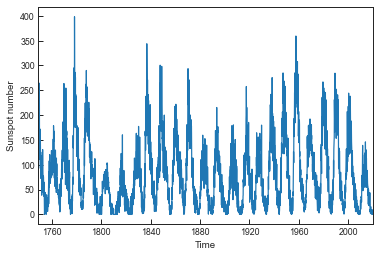

In [6]:
fig, ax = plt.subplots()
ax.plot(ssn_full['ssn'])
ax.set_xlim(ssn_full.index.min(), ssn_full.index.max())
ax.set_xlabel('Time')
ax.set_ylabel('Sunspot number')

Lets take a fourier transform of this to idenify periods - we should obviously identify the 11 year period. 

Text(0, 0.5, 'Power spectral density')

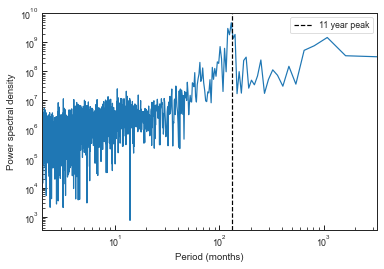

In [7]:
fft = fftpack.fft(ssn_full['ssn'].values)
freq = fftpack.fftfreq(fft.shape[-1], 1)
fig, ax = plt.subplots()
ax.loglog(1./freq[freq>0], np.abs(fft[freq>0])**2)
ax.axvline(11*12, ls='dashed', color='k', label='11 year peak')
ax.legend()
ax.set_xlim(2, len(ssn_full['ssn']))
ax.set_xlabel('Period (months)')
ax.set_ylabel('Power spectral density')

Lets just focus on last three solar cycle so we can truncate this data

In [8]:
ssn = ssn_full[ssn_full.index>'1986-09-01']

Text(0, 0.5, 'Sunspot number')

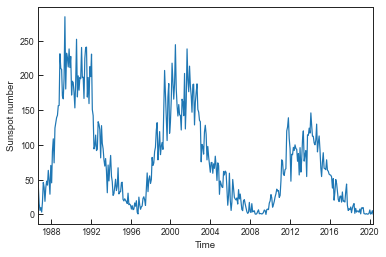

In [9]:
fig, ax = plt.subplots()
ax.plot(ssn['ssn'])
ax.set_xlim(ssn.index.min(), ssn.index.max())
ax.set_xlabel('Time')
ax.set_ylabel('Sunspot number')

## Now lets look at the GOES flare list
The csv I'm using here was created using the HEK client - there a function at the end of this notebook to create the csv if you want.

In [10]:
flares = pd.read_csv('since_1986_c1_solarcycle_flares.csv') 

the data can be inspected first to look at the column names I've given them

In [11]:
flares.head()

,event_starttime,event_peaktime,event_endtime,fl_goescls,ar_noaanum,goes_class,flare_times
0,1986-09-08T16:43:00,1986-09-08T16:44:00,1986-09-08T16:55:00,C2.6,4745,0.000003,1986-09-08 16:44:00
1,1986-10-13T00:09:00,1986-10-13T00:11:00,1986-10-13T00:14:00,C1.1,4748,0.000001,1986-10-13 00:11:00
2,1986-10-14T13:38:00,1986-10-14T14:50:00,1986-10-14T15:03:00,C2.2,0,0.000002,1986-10-14 14:50:00
3,1986-10-14T21:54:00,1986-10-14T22:23:00,1986-10-14T22:57:00,C3.3,4747,0.000003,1986-10-14 22:23:00
4,1986-10-15T21:12:00,1986-10-15T21:42:00,1986-10-15T21:42:00,C1.1,0,0.000001,1986-10-15 21:42:00


We can first just plot the flares GOES peak flux as a function of time

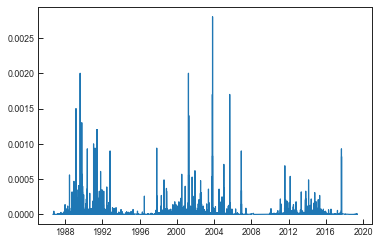

In [12]:
plt.plot(parse_time(flares['flare_times']).datetime, flares['goes_class'])

or we can plot this as a scatte plot - where we can also have that the color of each point represents the flare flux

Text(0, 0.5, 'Peak Flux')

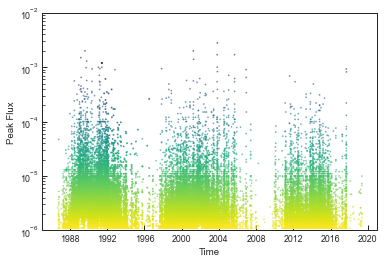

In [13]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.scatter(pd.to_datetime(flares['event_peaktime']), flares['goes_class'], 
           alpha=0.5, s=1, cmap='viridis_r', c=flares['goes_class'], norm=LogNorm())
ax.set_ylim(1e-6, 1e-2)
ax.set_xlabel('Time')
ax.set_ylabel('Peak Flux')

We can also plot the flares frequency as a histogram - however given there are so many more smaller flares than larger flares (it follows a power law) we should plot this with logarithmically spaced bins

Text(0, 0.5, 'Number of events')

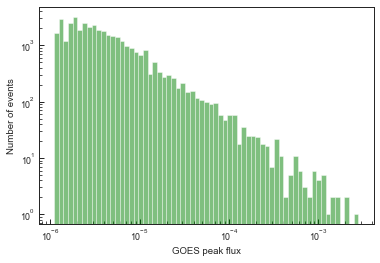

In [14]:
fig, ax = plt.subplots()
# first get the linear bins (bin size I just chose a random one)
n, linear_bins = np.histogram(flares['goes_class'], bins=65) 
# now define the log bins
logbins = np.logspace(np.log10(linear_bins[0]),np.log10(linear_bins[-1]),len(linear_bins))

n, bins, _ = ax.hist(flares['goes_class'], bins=logbins, alpha=0.5, color='green')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('GOES peak flux')
ax.set_ylabel('Number of events')

As shown it follows a nice power law shape - to do this properly and find frequency distribution you should probably divide the total number in each bin by the bin width ....

## Now lets make some pretty plots

Lets now plot the flares as a function of time with the sunspot number and also plot the above histogram

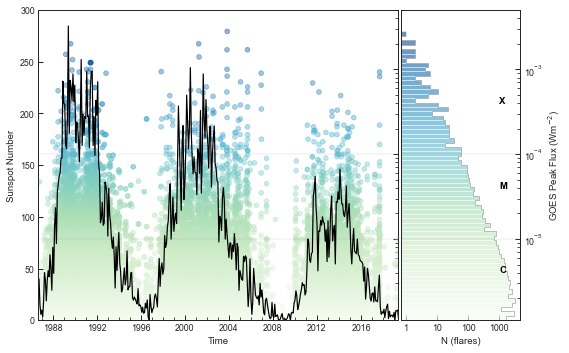

In [15]:
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(8, 5))

ax0.set_xlabel('Time')
ax01 = ax0.twinx()

ax01.set_yscale('log')
ax01.scatter(pd.to_datetime(flares['flare_times']), flares['goes_class'], c=flares['goes_class'], 
             norm=LogNorm(), cmap='GnBu', alpha=0.4)
ax01.tick_params(which='both',  direction='in', labelright=False)

ax01.set_ylim(flares['goes_class'].min(), 5e-3)
ax01.set_xlim(parse_time(flares['flare_times'].min()).datetime, parse_time(flares['flare_times'].max()).datetime)

ax0.plot(ssn['ssn'], color='k')
ax0.set_ylim(0, 300)
ax0.set_zorder(1)  
ax0.patch.set_visible(False) 
ax0.set_ylabel('Sunspot Number')
ax0.tick_params(which='both', direction='in') 
ax0.xaxis.set_major_locator(dates.YearLocator(4))
ax0.xaxis.set_minor_locator(dates.YearLocator(1))  
ax0.xaxis.set_major_formatter(dates.DateFormatter('%Y'))  

# plot the histogram
Na, binsa, patches = ax1.hist(flares['goes_class'], orientation='horizontal', 
                              bins=logbins, alpha=0.6)

ax1.step(Na, binsa[:-1], color='grey', lw=0.5) #overplot step

# this part is to color the histogram based on bin values
fracs = linear_bins
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.get_cmap('GnBu')(norm(thisfrac))
    thispatch.set_facecolor(color)


ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(flares['goes_class'].min(), 5e-3)
ax1.tick_params(which='both',  direction='in', labelleft=False, labelright=True,  
                left=False, right=True)
ax1.set_ylabel('GOES Peak Flux (Wm$^{-2}$)')
ax1.yaxis.set_label_position("right")
ax1.set_xticks([1,10,100, 1000]) 
ax1.xaxis.set_major_formatter(ScalarFormatter())

ax1.axhline(1e-5, color='grey', lw=0.2, ls='dashed')
ax01.axhline(1e-5, color='grey', lw=0.2, ls='dashed')
ax1.axhline(1e-4, color='grey', lw=0.2, ls='dashed')
ax01.axhline(1e-4, color='grey', lw=0.2, ls='dashed')    

ax1.text(1000, 4e-6, 'C', color='k', fontweight='bold')
ax1.text(1000, 4e-5, 'M', color='k', fontweight='bold')
ax1.text(1000, 4e-4, 'X', color='k', fontweight='bold')


ax1.set_xlabel('N (flares)')
plt.tight_layout()
plt.subplots_adjust(wspace=0.01)
plt.savefig('solar_flare_snn.png', dpi=200, bbox_inches = 'tight')

In [16]:
flares['index_times'] = pd.to_datetime(flares['event_peaktime'])
flares2 = flares.set_index('event_peaktime')
flares2.sort_index(inplace=True)

In [17]:
flares2.index.max()

'2019-05-15T19:24:00'

In [18]:

flares_sc22 = flares2.truncate('1989-09-01', '1996-08-01')
flares_sc23 = flares2.truncate('1996-08-01', '2008-12-01')
flares_sc24 = flares2.truncate('2008-12-01', '2019-12-02')

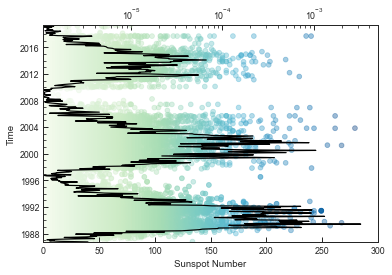

In [19]:
fig, ax0 = plt.subplots(1)

ax0.set_ylabel('Time')
ax01 = ax0.twiny()

ax01.set_xscale('log')
ax01.scatter(flares['goes_class'], pd.to_datetime(flares['flare_times']), c=flares['goes_class'], 
             norm=LogNorm(), cmap='GnBu', alpha=0.4)
ax01.tick_params(which='both',  direction='in', labelright=False)

ax01.set_xlim(flares['goes_class'].min(), 5e-3)
ax01.set_ylim(parse_time(flares['flare_times'].min()).datetime, parse_time(flares['flare_times'].max()).datetime)

ax0.plot(ssn['ssn'], ssn.index, color='k')
ax0.set_xlim(0, 300)
ax0.set_zorder(1)  
ax0.patch.set_visible(False) 
ax0.set_xlabel('Sunspot Number')
ax0.tick_params(which='both', direction='in') 
ax0.yaxis.set_major_locator(dates.YearLocator(4))
ax0.yaxis.set_minor_locator(dates.YearLocator(1))  
ax0.yaxis.set_major_formatter(dates.DateFormatter('%Y'))  





Text(0, 0.5, 'Number of events')

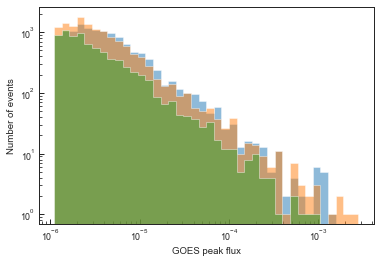

In [20]:
def get_logbins(flares, bins=55):
    n, linear_bins = np.histogram(flares['goes_class'], bins=bins) 
    logbins = np.logspace(np.log10(linear_bins[0]),np.log10(linear_bins[-1]),len(linear_bins))
    return logbins

all_logbins = get_logbins(flares_sc23, bins=40)

fig, ax = plt.subplots()
n22, bins22, _ = ax.hist(flares_sc22['goes_class'], bins=all_logbins, alpha=0.5, histtype='stepfilled')
n23, bins23, _ = ax.hist(flares_sc23['goes_class'], bins=all_logbins, alpha=0.5, histtype='stepfilled')
n24, bins24, _ = ax.hist(flares_sc24['goes_class'], bins=all_logbins, alpha=0.5, histtype='stepfilled')


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('GOES peak flux')
ax.set_ylabel('Number of events')

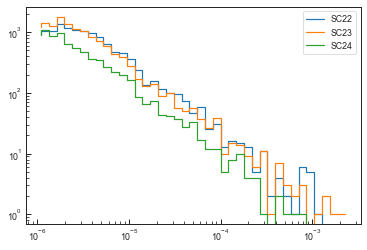

In [21]:
fig, ax = plt.subplots()
ax.step(bins22[:-1], n22, label='SC22')
ax.step(bins23[:-1], n23, label='SC23')
ax.step(bins24[:-1], n24, label='SC24')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

In [22]:
len(flares_sc22)

12963

## Here's a function to generate the GOES csv file used in this notebook 

Just note that at the moment querying the HEK is super slow - don't know why, probably should look into it .....

In [23]:
def make_goes_flare_csv():
    
    client = hek.HEKClient()
    event_type = 'FL'

    tstart = '1986/09/01'
    tend = '2020/06/16'

    import time
    t1 = time.time()
    result_m1 = client.search(hek.attrs.Time(tstart, tend),
                              hek.attrs.EventType(event_type),
                              hek.attrs.FL.GOESCls > 'C1.0',
                              hek.attrs.OBS.Observatory == 'GOES')

    print(time.time() - t1)

    new_table = result_m1[['event_starttime', 'event_peaktime',
                           'event_endtime', 'fl_goescls', 'ar_noaanum', ]]

    def get_goes_class(all_data):
        goes_class = []
        goes_class_index = []
        for i in range(len(all_data)):
            #print(i)
            try:
                if all_data[i]['fl_goescls'][0] == 'C':
                    gc = float(all_data[i]['fl_goescls'][1:])*(1e-6)
                    gc1 = 'C'
                elif all_data[i]['fl_goescls'][0] == 'M':
                    gc = float(all_data[i]['fl_goescls'][1:])*(1e-5)
                    gc1 = 'M'
                elif all_data[i]['fl_goescls'][0] == 'X':
                    gc = float(all_data[i]['fl_goescls'][1:])*(1e-4)
                    gc1 = 'X'          
                else:
                    print ('somethings wrong')
            except:
                gc = 0
                print(i)
            goes_class.append(gc)
            goes_class_index.append(gc1)
        return goes_class

    goes_class = get_goes_class(new_table)
    new_table['goes_class'] = goes_class

    flare_times = parse_time(new_table['event_peaktime']).datetime
    new_table['flare_times'] = flare_times

    new_table = new_table[new_table['goes_class']!=0]

    new_table = unique(new_table, keys='event_starttime')

    new_table.write('since_1986_c1_solarcycle_flares.csv', format='csv')